# **问题3**

In [ ]:
! pip install --upgrade xlrd
! pip install pandas==1.2.0
! pip install xgboost
! pip install lightgbm 
! pip install matplotlib 
! pip install mplfonts 
! pip install pybaobabdt 
! apt install libgraphviz-dev
! pip install pygraphviz
! pip install pydotplus

In [ ]:
import warnings 
import chardet
import pybaobabdt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import numpy as np 
from sklearn.metrics import r2_score,classification_report,f1_score,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('Noto Serif CJK SC')#指定中文字体
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# 附件14是12 14 16 18 20年
# 附件15是16 17 18 19 20年
# 只合并相同的16 18 20年
attachment_14 = pd.read_excel('附件14不同放牧强度土壤碳氮监测数据.xlsx')
tmp1=attachment_14[attachment_14.year==2020]
tmp2=attachment_14[attachment_14.year==2018]
tmp3=attachment_14[attachment_14.year==2016]
attachment_14=pd.concat([tmp1,tmp2,tmp3],axis=0)
attachment_14

,year,放牧小区（plot）,放牧强度（intensity）,SOC土壤有机碳,SIC土壤无机碳,STC土壤全碳,全氮N,土壤C/N比
120,2020,G17,NG,16.858300,6.08675,22.945050,2.115200,10.847698
121,2020,G19,NG,17.298500,4.30145,21.599950,2.198050,9.826869
122,2020,G21,NG,20.133500,4.06490,24.198400,2.431150,9.953479
123,2020,G6,LGI,14.789650,3.00120,17.790850,2.016500,8.822638
124,2020,G12,LGI,16.185800,3.80290,19.988700,1.944800,10.278023
...,...,...,...,...,...,...,...,...
79,2016,G11,MGI,10.963060,9.60000,20.563060,1.359518,15.125255
80,2016,G16,MGI,7.774036,9.35000,17.124036,0.841584,20.347399
81,2016,G9,HGI,9.519351,11.10000,20.619351,1.280125,16.107292
82,2016,G13,HGI,11.185712,10.80000,21.985712,1.406743,15.628800


In [ ]:
# 输出文件原格式
def  GetEncodingSheme(_filename):
    with open(_filename, 'rb') as file:
        buf = file.read()
    result = chardet.detect(buf)
    return result['encoding']

# 原格式转换为utf-8
def ChangeEncoding(_infilename, _outfilname, _encodingsheme='utf-8'):
  ifEncodeSheme = GetEncodingSheme(_infilename)
  with open(_infilename, 'r', encoding=ifEncodeSheme) as fr:
    tempContent = fr.read()
  with open(_outfilname, 'w', encoding=_encodingsheme) as fw:
    fw.write(tempContent)

filename = '附件15群落结构监测数据集.csv'
print('原格式为：', GetEncodingSheme(filename)) #输出原格式
ChangeEncoding('附件15群落结构监测数据集.csv', '附件15群落结构监测数据集_new.csv', 'utf-8') #格式转化为utf-8
print('文件已转换为utf-8编码')

原格式为： GB2312
文件已转换为utf-8编码


In [ ]:
f=open('附件15群落结构监测数据集_new.csv')
attachment_15=pd.read_csv(f,encoding='utf-8')
tmp1=attachment_15[attachment_15.年份==2020]
tmp2=attachment_15[attachment_15.年份==2018]
tmp3=attachment_15[attachment_15.年份==2016]
attachment_15=pd.concat([tmp1,tmp2,tmp3],axis=0)
attachment_15

,年份,轮次,处理,日期,植物种名,植物群落功能群,放牧小区Block,重复,营养苗,生殖苗,株/丛数,丛幅1,丛幅2,鲜重(g),干重(g)
2261,2020,牧前,轻牧（3天）,2020.5.29,大针茅,PB,G6,1,30.0,NaN,11.0,6.0,10.0,115.01,57.99
2262,2020,牧前,轻牧（3天）,2020.5.29,糙隐子草,PB,G6,1,4.0,NaN,31.0,4.0,3.0,9.13,5.13
2263,2020,牧前,轻牧（3天）,2020.5.29,羊草,PR,G6,1,14.0,NaN,69.0,NaN,NaN,20.58,8.54
2264,2020,牧前,轻牧（3天）,2020.5.29,知母,PF,G6,1,7.0,NaN,7.0,NaN,NaN,1.73,0.53
2265,2020,牧前,轻牧（3天）,2020.5.29,猪毛菜,AB,G6,1,4.0,NaN,1.0,NaN,NaN,0.24,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10876,2016,第四轮牧后,无牧（0天）,2016.9.21,米氏冰草,PR,G21,4,30.0,NaN,64.0,NaN,NaN,100.97,62.43
10877,2016,第四轮牧后,无牧（0天）,2016.9.21,羊草,PR,G21,5,57.0,NaN,150.0,NaN,NaN,155.52,90.01
10878,2016,第四轮牧后,无牧（0天）,2016.9.21,大针茅,PB,G21,5,50.0,70.0,8.0,4.0,4.0,45.55,29.93
10879,2016,第四轮牧后,无牧（0天）,2016.9.21,知母,PF,G21,5,34.0,NaN,25.0,NaN,NaN,47.21,18.87


In [ ]:
# 附件14 15 生成合并索引bloar=小区-年份 如G6-2012
attachment_14['bloar']=attachment_14.apply(lambda x:x['放牧小区（plot）']+'-'+str(x['year']),axis=1)
attachment_15['bloar']=attachment_15.apply(lambda x:x['放牧小区Block']+'-'+str(x['年份']),axis=1)

In [ ]:
# 以bloar列为索引 合并附件14 15
attachment_1415=pd.merge(attachment_14,attachment_15,on='bloar')
attachment_1415

,year,放牧小区（plot）,放牧强度（intensity）,SOC土壤有机碳,SIC土壤无机碳,STC土壤全碳,全氮N,土壤C/N比,bloar,年份,...,植物群落功能群,放牧小区Block,重复,营养苗,生殖苗,株/丛数,丛幅1,丛幅2,鲜重(g),干重(g)
0,2020,G17,NG,16.858300,6.08675,22.945050,2.115200,10.847698,G17-2020,2020,...,PB,G17,1,15.0,NaN,2.0,2.0,2.0,0.95,0.50
1,2020,G17,NG,16.858300,6.08675,22.945050,2.115200,10.847698,G17-2020,2020,...,PB,G17,1,4.0,NaN,6.0,3.0,4.0,3.41,1.53
2,2020,G17,NG,16.858300,6.08675,22.945050,2.115200,10.847698,G17-2020,2020,...,PR,G17,1,12.0,NaN,30.0,5.0,4.0,77.95,34.75
3,2020,G17,NG,16.858300,6.08675,22.945050,2.115200,10.847698,G17-2020,2020,...,PR,G17,1,27.0,NaN,210.0,NaN,NaN,105.45,43.93
4,2020,G17,NG,16.858300,6.08675,22.945050,2.115200,10.847698,G17-2020,2020,...,PF,G17,1,20.0,NaN,30.0,NaN,NaN,42.18,13.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292,2016,G20,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,G20-2016,2016,...,PB,G20,5,25.0,33.0,20.0,4.0,4.0,141.41,88.49
14293,2016,G20,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,G20-2016,2016,...,PF,G20,5,4.0,NaN,17.0,NaN,NaN,0.90,0.35
14294,2016,G20,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,G20-2016,2016,...,PB,G20,5,3.0,NaN,16.0,2.0,2.0,1.99,1.26
14295,2016,G20,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,G20-2016,2016,...,PR,G20,5,5.0,NaN,5.0,NaN,NaN,1.63,1.21


In [ ]:
# 不同列缺失值数量 生殖苗过多 认为是无关项
attachment_1415.isnull().sum()

year                   0
放牧小区（plot）             0
放牧强度（intensity）        0
SOC土壤有机碳               0
SIC土壤无机碳               0
STC土壤全碳                0
全氮N                    0
土壤C/N比                 0
bloar                  0
年份                     0
轮次                     0
处理                     0
日期                     0
植物种名                   0
植物群落功能群                0
放牧小区Block              0
重复                     0
营养苗                   24
生殖苗                12581
株/丛数                 357
丛幅1                 9438
丛幅2                10054
鲜重(g)                705
干重(g)                  0
dtype: int64

Text(0, 0.5, '数量')

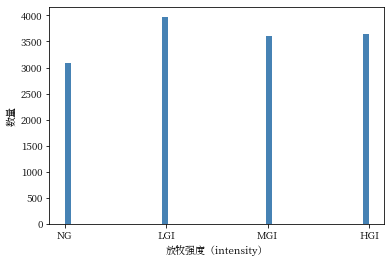

In [ ]:
# 人为保留相关项
# '放牧小区（plot）', '轮次'                        ——放牧方式 只考虑选择划区轮牧
# '放牧强度（intensity）'）                         ——放牧强度 附件14的放牧强度(NG LGI MGI HGI)和附件15的处理(无牧（0天） 轻牧（3天） 中牧（6天）重牧（12天）)完全对应 仅保留一个就行
#  'SOC土壤有机碳', 'SIC土壤无机碳','STC土壤全碳', '全氮N', '土壤C/N比' ——化学性质
attachment_1415=attachment_1415[['年份', '放牧小区（plot）', '轮次',
                  '放牧强度（intensity）',
                  'SOC土壤有机碳', 'SIC土壤无机碳','STC土壤全碳', '全氮N', '土壤C/N比']]

plt.hist(attachment_1415['放牧强度（intensity）'], bins=50, color='steelblue')
plt.xlabel('放牧强度（intensity）')
plt.ylabel('数量')

Text(0, 0.5, '数量')

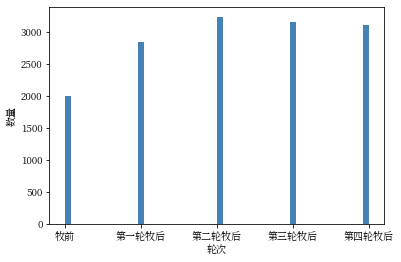

In [ ]:
plt.hist(attachment_1415['轮次'], bins=50, color='steelblue')
plt.xlabel('轮次')
plt.ylabel('数量')

Text(0, 0.5, '数量')

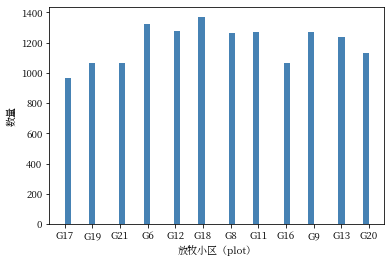

In [ ]:
plt.hist(attachment_1415['放牧小区（plot）'], bins=50, color='steelblue')
plt.xlabel('放牧小区（plot）')
plt.ylabel('数量')

In [ ]:
# 放牧方式量化
# 将小区号 轮次号进行one-hot编码 1代表attachment_1415本行原本是该小区号/轮次号
attachment_1415=pd.concat([attachment_1415,pd.get_dummies(attachment_1415['放牧小区（plot）'],prefix='小区号_')],axis=1)#12列
attachment_1415=pd.concat([attachment_1415,pd.get_dummies(attachment_1415['轮次'],prefix='轮次_')],axis=1)#5列
attachment_1415

,年份,放牧小区（plot）,轮次,放牧强度（intensity）,SOC土壤有机碳,SIC土壤无机碳,STC土壤全碳,全氮N,土壤C/N比,小区号__G11,...,小区号__G20,小区号__G21,小区号__G6,小区号__G8,小区号__G9,轮次__牧前,轮次__第一轮牧后,轮次__第三轮牧后,轮次__第二轮牧后,轮次__第四轮牧后
0,2020,G17,牧前,NG,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
1,2020,G17,牧前,NG,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
2,2020,G17,牧前,NG,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
3,2020,G17,牧前,NG,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
4,2020,G17,牧前,NG,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292,2016,G20,第四轮牧后,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1
14293,2016,G20,第四轮牧后,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1
14294,2016,G20,第四轮牧后,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1
14295,2016,G20,第四轮牧后,HGI,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
# 放牧强度量化
# 对照（NG， 0羊/天/公顷 ）、轻度放牧强度（LGI， 2羊/天/公顷 ）、中度放牧强度（MGI，4羊/天/公顷 ）和重度放牧强度（HGI，8羊/天/公顷 ）
attachment_1415['放牧强度（intensity）']=attachment_1415['放牧强度（intensity）'].map(
{
    'NG':0,
    'LGI':2, 
    'MGI':4, 
    'HGI':8
})
attachment_1415

,年份,放牧小区（plot）,轮次,放牧强度（intensity）,SOC土壤有机碳,SIC土壤无机碳,STC土壤全碳,全氮N,土壤C/N比,小区号__G11,...,小区号__G20,小区号__G21,小区号__G6,小区号__G8,小区号__G9,轮次__牧前,轮次__第一轮牧后,轮次__第三轮牧后,轮次__第二轮牧后,轮次__第四轮牧后
0,2020,G17,牧前,0,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
1,2020,G17,牧前,0,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
2,2020,G17,牧前,0,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
3,2020,G17,牧前,0,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
4,2020,G17,牧前,0,16.858300,6.08675,22.945050,2.115200,10.847698,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292,2016,G20,第四轮牧后,8,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1
14293,2016,G20,第四轮牧后,8,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1
14294,2016,G20,第四轮牧后,8,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1
14295,2016,G20,第四轮牧后,8,9.432948,13.25000,22.682948,1.279183,17.732372,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
# 重新选择
attachment_1415=attachment_1415[['年份', '放牧强度（intensity）',
       '小区号__G11', '小区号__G12', '小区号__G13','小区号__G16', '小区号__G17', '小区号__G18', '小区号__G19', '小区号__G20','小区号__G21', '小区号__G6', '小区号__G8', '小区号__G9', 
       '轮次__牧前', '轮次__第一轮牧后', '轮次__第二轮牧后','轮次__第三轮牧后', '轮次__第四轮牧后',
       'SOC土壤有机碳', 'SIC土壤无机碳','STC土壤全碳', '全氮N', '土壤C/N比'
       ]]
attachment_1415

,年份,放牧强度（intensity）,小区号__G11,小区号__G12,小区号__G13,小区号__G16,小区号__G17,小区号__G18,小区号__G19,小区号__G20,...,轮次__牧前,轮次__第一轮牧后,轮次__第二轮牧后,轮次__第三轮牧后,轮次__第四轮牧后,SOC土壤有机碳,SIC土壤无机碳,STC土壤全碳,全氮N,土壤C/N比
0,2020,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,16.858300,6.08675,22.945050,2.115200,10.847698
1,2020,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,16.858300,6.08675,22.945050,2.115200,10.847698
2,2020,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,16.858300,6.08675,22.945050,2.115200,10.847698
3,2020,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,16.858300,6.08675,22.945050,2.115200,10.847698
4,2020,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,16.858300,6.08675,22.945050,2.115200,10.847698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292,2016,8,0,0,0,0,0,0,0,1,...,0,0,0,0,1,9.432948,13.25000,22.682948,1.279183,17.732372
14293,2016,8,0,0,0,0,0,0,0,1,...,0,0,0,0,1,9.432948,13.25000,22.682948,1.279183,17.732372
14294,2016,8,0,0,0,0,0,0,0,1,...,0,0,0,0,1,9.432948,13.25000,22.682948,1.279183,17.732372
14295,2016,8,0,0,0,0,0,0,0,1,...,0,0,0,0,1,9.432948,13.25000,22.682948,1.279183,17.732372


In [ ]:
attachment_1415.isnull().sum()/attachment_1415.shape[0]#计算缺失比例

年份                 0.0
放牧强度（intensity）    0.0
小区号__G11           0.0
小区号__G12           0.0
小区号__G13           0.0
小区号__G16           0.0
小区号__G17           0.0
小区号__G18           0.0
小区号__G19           0.0
小区号__G20           0.0
小区号__G21           0.0
小区号__G6            0.0
小区号__G8            0.0
小区号__G9            0.0
轮次__牧前             0.0
轮次__第一轮牧后          0.0
轮次__第二轮牧后          0.0
轮次__第三轮牧后          0.0
轮次__第四轮牧后          0.0
SOC土壤有机碳           0.0
SIC土壤无机碳           0.0
STC土壤全碳            0.0
全氮N                0.0
土壤C/N比             0.0
dtype: float64

In [ ]:
# 3sigma 去极值
def filter_extreme_3sigma(dataframe,n=3):
  for i in dataframe.columns:
    mean=dataframe[i].mean()
    std=dataframe[i].std()
    max_range=mean+n*std
    min_range=mean-n*std
    dataframe[i] = pd.DataFrame(np.clip(dataframe[i].values, min_range, max_range), columns=None)
  return dataframe
attachment_1415=filter_extreme_3sigma(attachment_1415)

In [ ]:
# 需要预测的数据
data = pd.read_excel('需要预测的值.xlsx')
data = pd.concat([data,pd.get_dummies(data['放牧小区（plot）'],prefix='小区号_')],axis=1)#12列
data['放牧强度（intensity）']=data['放牧强度（intensity）'].map(
{
    'NG':0,
    'LGI':2, 
    'MGI':4, 
    'HGI':8
})
data = data[['放牧强度（intensity）',
       '小区号__G11', '小区号__G12', '小区号__G13','小区号__G16', '小区号__G17', '小区号__G18', '小区号__G19', '小区号__G20','小区号__G21', '小区号__G6', '小区号__G8', '小区号__G9', 
       'SOC土壤有机碳', 'SIC土壤无机碳','STC土壤全碳', '全氮N', '土壤C/N比'
       ]]
data

,放牧强度（intensity）,小区号__G11,小区号__G12,小区号__G13,小区号__G16,小区号__G17,小区号__G18,小区号__G19,小区号__G20,小区号__G21,小区号__G6,小区号__G8,小区号__G9,SOC土壤有机碳,SIC土壤无机碳,STC土壤全碳,全氮N,土壤C/N比
0,0,0,0,0,0,1,0,0,0,0,0,0,0,17,12,27,2,12
1,0,0,0,0,0,0,0,1,0,0,0,0,0,18,4,22,2,9
2,0,0,0,0,0,0,0,0,0,1,0,0,0,22,1,23,2,8
3,2,0,0,0,0,0,0,0,0,0,1,0,0,14,10,20,2,8
4,2,0,1,0,0,0,0,0,0,0,0,0,0,16,8,19,1,15
5,2,0,0,0,0,0,1,0,0,0,0,0,0,21,11,23,2,13
6,4,0,0,0,0,0,0,0,0,0,0,1,0,18,1,15,1,8
7,4,1,0,0,0,0,0,0,0,0,0,0,0,14,2,18,1,9
8,4,0,0,0,1,0,0,0,0,0,0,0,0,7,9,30,0,20
9,8,0,0,0,0,0,0,0,0,0,0,0,1,12,8,20,2,12


In [ ]:
# 模型评估
def performance_metric(y_true, y_predict):
    """计算并返回预测值相比于预测值的分数"""
    score = r2_score(y_true,y_predict)
    return score

def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    cross_validator = KFold()
    regressor = DecisionTreeRegressor()
    params = {"max_depth":np.arange(1,11)}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor,params,scoring=scoring_fnc)
    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    print(pd.DataFrame(grid.cv_results_))
    # 返回网格搜索后的最优模型
    return grid.best_estimator_

In [ ]:
# 模型训练
X=attachment_1415[['放牧强度（intensity）',
  '小区号__G11', '小区号__G12', '小区号__G13','小区号__G16', '小区号__G17', '小区号__G18', '小区号__G19', '小区号__G20','小区号__G21', '小区号__G6', '小区号__G8', '小区号__G9']]
from IPython.display import Image  
from sklearn import tree
import pydotplus 

y_SOC=attachment_1415['SOC土壤有机碳']
y_SIC=attachment_1415['SIC土壤无机碳']
y_STC=attachment_1415['STC土壤全碳']
y_N =attachment_1415['全氮N']
y_CN=attachment_1415['土壤C/N比']

X_data=data[['放牧强度（intensity）',
  '小区号__G11', '小区号__G12', '小区号__G13','小区号__G16', '小区号__G17', '小区号__G18', '小区号__G19', '小区号__G20','小区号__G21', '小区号__G6', '小区号__G8', '小区号__G9']]

count=0
name=['y_SOC','y_SIC','y_STC','y_N','y_CN']
for y in [y_SOC,y_SIC,y_STC,y_N,y_CN] :
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
  
  print('当前预测指标为：',name[count])
  

  #训练拟合
  # 决策树 基于训练数据，获得最优模型
  optimal_model = fit_model(x_train,y_train)
  print('最优模型', optimal_model)
  dot_data = tree.export_graphviz(optimal_model, out_file=None)
  graph = pydotplus.graph_from_dot_data(dot_data)
  s=name[count]+'.png'
  graph.write_png(s)
  # 输出最优模型的 'max_depth' 参数
  print("Parameter 'max_depth' is {} for the optimal model.".format(optimal_model.get_params()['max_depth']))

  #验证
  y_pred=optimal_model.predict(x_test)
  #print('预测值：',y_pred)
  #print('真实值：',y_test)
  #print(classification_report(y_pred,y_test.))

  #模型评估
  score = performance_metric(y_test,y_pred)
  print('score:', score)
  #print('coef_', optimal_model.coef_)
  #print('intercept_', optimal_model.intercept_)

  # 推理
  y_data=optimal_model.predict(X_data)
  print('需要预测的值：',y_data)

  count+=1


当前预测指标为： y_SOC
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.004164      0.000349         0.002104        0.000078   
1       0.004278      0.000082         0.002105        0.000060   
2       0.004689      0.000099         0.002067        0.000024   
3       0.005228      0.000456         0.002115        0.000046   
4       0.005188      0.000149         0.002241        0.000162   
5       0.006166      0.001018         0.002916        0.000833   
6       0.005568      0.000526         0.002150        0.000070   
7       0.005473      0.000675         0.002067        0.000033   
8       0.005373      0.000182         0.002112        0.000037   
9       0.005268      0.000180         0.002099        0.000023   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               1   {'max_depth': 1}           0.024870           0.011888   
1               2   {'max_depth': 2}           0.047756           0.035014   
2            